# WDI plots

* http://datatopics.worldbank.org/world-development-indicators/

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pylab as plt
pd.set_option('display.width',140)
from bokeh.io import show, output_notebook, export_png
from bokeh.models import ColumnDataSource, ColorBar, HoverTool
from bokeh.tile_providers import get_provider, Vendors
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider, Select

output_notebook()
#output_file('test.html')

import panel as pn
from panel.interact import interact, interactive, fixed, interact_manual
from panel import widgets

pn.extension()

Loading BokehJS ...

ImportError: cannot import name 'encode_utf8' from 'bokeh.util.string' (/usr/local/lib/python3.7/dist-packages/bokeh/util/string.py)

## load the WDI data

In [ ]:
wdi = pd.read_csv('data/WDIData.csv.gz')
#country names only
countries = list(wdi['Country Name'].unique()[47:])
scountries = ['Zimbabwe','Zambia','Botswana','Namibia','South Africa']
#indicator names
names = list(wdi['Indicator Name'])
wdi = wdi[wdi['Country Name'].isin(countries)]
print (wdi[20:25])

## matplotlib line plots

In [73]:
from matplotlib.figure import Figure
from cycler import cycler

def plot_col(df, col, kind='line', color=True):
    """plot a specific column"""
    
    fig = Figure(figsize=(10, 6))
    ax = fig.subplots() 
    ax.set_title(col)
    default_cycler = ( cycler('linestyle', ['-', '--', ':', '-.']))
    if color == False:       
        plt.rc('axes', prop_cycle=default_cycler)
        df.plot(lw=3,ax=ax,kind=kind,color='black') 
    else:        
        cmap='Spectral'  
        df.plot(lw=3,ax=ax,kind=kind,cmap=cmap,linestyle='-') 
    return fig

def get_data(col,years=None,countries=None):
    """get data from the wdi dataframe"""
    
    x = wdi.set_index('Indicator Name')
    x = x.loc[col].set_index('Country Name')
    if countries!=None:
        x = x.loc[countries]
    x = x[x.columns[3:-2]]
    x = x.T
    x.index=x.index.astype(int)
    if years!=None:
        x = x.loc[years]    
    return x

col=wdi.iloc[64]['Indicator Name']
df = get_data(col)
fig=plot_col(df, col)
fig.savefig('%s.png' %col,dpi=200)

## panel app for interactive plot

Row
    [0] Column
        [0] Select(name='Indicator', options=['2005 PPP conversion fact...], value='Adjusted net n...)
        [1] MultiSelect(name='Country', options=['Afghanistan', ...], size=8, value=['Zimbabwe', 'Zambia', ...])
        [2] RangeSlider(end=2019, name='Dates', start=1961, step=1, value=(1961, 2019))
        [3] Select(name='Plot kind', options=['line', 'area'], value='line')
        [4] Checkbox(name='Color', value=True)
    [1] ParamFunction(function)
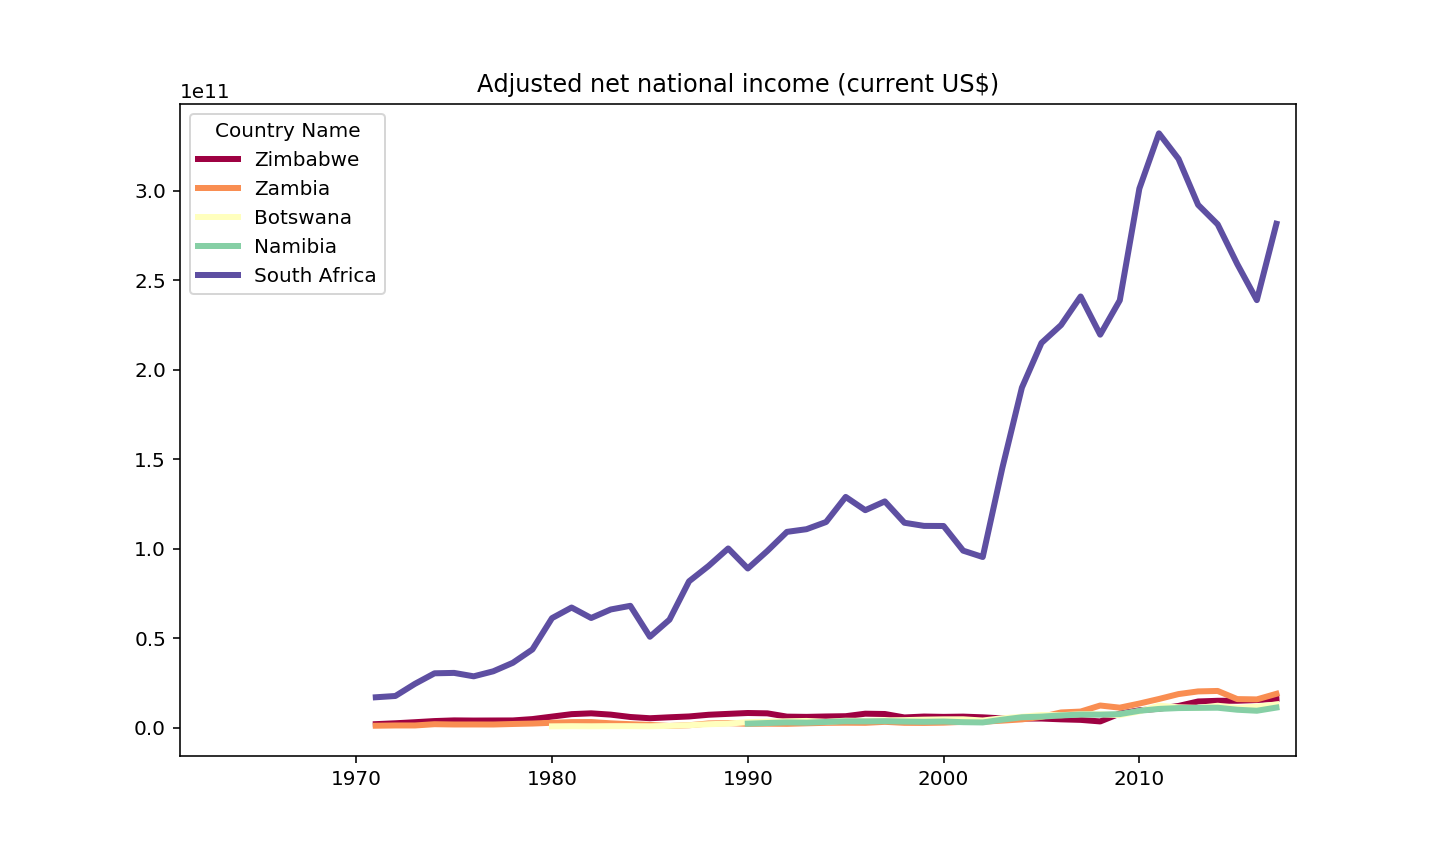

In [74]:
select=pn.widgets.Select(name='Indicator',options=names[:900],value=names[24])
daterange = pn.widgets.RangeSlider(name='Dates', start=1961, end=2019, value=(1961,2019), step=1)
countryselect = pn.widgets.MultiSelect(name='Country',options=countries,value=scountries,size=8)
typeselect = pn.widgets.Select(name='Plot kind',options=['line','area'])
colorselect = pn.widgets.Checkbox(name='Color',value=True)

@pn.depends(select.param.value,daterange.param.value,
            countryselect.param.value,typeselect.param.value,colorselect.param.value)
def update(col, years, countries, kind, color):
    years = range(years[0],years[1])
    df = get_data(col,years,countries)    
    f = plot_col(df, col, kind, color)
    return f

app = pn.Row(pn.Column(select,countryselect,daterange,typeselect,colorselect), update)
app

## bokeh plot

In [ ]:
from bokeh.models.widgets import Select
from bokeh.layouts import gridplot, column

def bokeh_plot_col(attr, old, new):
    """Bokeh plot WDI indicators"""
    
    col = select.value
    x = wdi.set_index('Indicator Name')
    x = x.loc[col]    
    m = pd.melt(x, id_vars=['Country Name'], value_vars=wdi.columns[4:-1])
    #print (m)
    source = ColumnDataSource(m)
    from bokeh.palettes import Spectral11
    mypalette=Spectral11[0:4]
    p = figure(plot_width=600,plot_height=400,tools="hover,xwheel_zoom,xpan")   
    line = p.line(x='variable',y='value',source=source,line_width=5)
    #p.legend()
    p.grid.visible = False
    
    return p

select = Select(title="Option:", value=names[0], options=names[:345])
select.on_change('value', bokeh_plot_col)

p1 = bokeh_plot_col(None,None,None)    
p = gridplot([[select,p1]], toolbar_location='below')
show(p)

In [ ]:
app.servable()